In [12]:
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### Question 2  

How has the collaboration network and its properties evolved over time? That is,
the program should be able to analyze the network properties over time (at
yearly granularity).

In [13]:
papers_df = pd.read_csv('data/papers_cleaned.csv')
scientists_df = pd.read_csv('data/scientists_clean.csv')

In [14]:
def parse_authors(authors_str):
    if pd.isnull(authors_str):
        return []
    authors_str = authors_str.strip()
    # If the string starts with '[' it is likely a list-like representation
    if authors_str.startswith('['):
        try:
            authors_list = ast.literal_eval(authors_str)
            if isinstance(authors_list, list):
                return [str(a).strip() for a in authors_list]
            else:
                return []
        except Exception:
            return []
    else:
        # Otherwise assume authors are comma-separated
        return [a.strip() for a in authors_str.split(',') if a.strip()]

papers_df['authors_list'] = papers_df['Authors'].apply(parse_authors)

In [15]:
papers_df

,Title,Year,DOI,Authors,file,authors_list
0,IDoFew: Intermediate Training Using Dual-Clust...,2024,https://doi.org/10.48550/arXiv.2401.04025,['94-10440'],94-10440.xml,[94-10440]
1,CLEFT: Contextualised Unified Learning of User...,2023,https://doi.org/10.1109/ACCESS.2023.3245982,['94-10440'],94-10440.xml,[94-10440]
2,Graph-Aware Deep Fusion Networks for Online Sp...,2023,https://doi.org/10.1109/TCSS.2022.3189813,['94-10440'],94-10440.xml,[94-10440]
3,NLP-Crowdsourcing Hybrid Framework for Inter-R...,2023,https://doi.org/10.1109/THMS.2023.3319290,['94-10440'],94-10440.xml,[94-10440]
4,Topics in Contextualised Attention Embeddings.,2023,https://doi.org/10.1007/978-3-031-28238-6_15,['94-10440'],94-10440.xml,[94-10440]
...,...,...,...,...,...,...
101693,M-CAFE: Managing MOOC Student Feedback with Co...,2015,https://doi.org/10.1145/2724660.2728681,['147-1189'],147-1189.xml,[147-1189]
101694,A Case Study in Mobile-Optimized vs. Responsiv...,2015,https://doi.org/10.1145/2786567.2787135,['147-1189'],147-1189.xml,[147-1189]
101695,M-CAFE 1.0: Motivating and Prioritizing Ongoin...,2015,https://doi.org/10.1145/2808006.2808020,['147-1189'],147-1189.xml,[147-1189]
101696,Communication-Efficient Distributed Dual Coord...,2014,https://proceedings.neurips.cc/paper/2014/hash...,['147-1189'],147-1189.xml,[147-1189]


In [16]:
yearly_stats = {}
year_networks = {}
# Group papers by the publication year
for year, group in papers_df.groupby('Year'):
    G = nx.Graph()
    
    for _, row in group.iterrows():
        authors = row['authors_list']
        # Ensure every author appears as a node
        for author in authors:
            G.add_node(author)
        # Add an edge for every pair of co-authors
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                G.add_edge(authors[i], authors[j])

    if G.number_of_nodes() > 0:
        year_networks[year] = G
    elif G.number_of_nodes() == 0:
        continue  # Skip years with no authors
    
    # Compute network properties
    real_num_nodes = G.number_of_nodes()
    real_num_edges = G.number_of_edges()
    real_avg_degree = sum(dict(G.degree()).values()) / real_num_nodes
    real_avg_clustering = nx.average_clustering(G)
    real_num_components = nx.number_connected_components(G)
    real_largest_cc_size = len(max(nx.connected_components(G), key=len))
    real_max_degree = max(dict(G.degree()).values())
    
    # Compute average shortest path length on the largest connected component
    real_largest_cc = max(nx.connected_components(G), key=len)
    real_G_lcc = G.subgraph(real_largest_cc)
    real_avg_shortest_path_length = nx.average_shortest_path_length(real_G_lcc)
    
    # Compute closeness centrality for all nodes in G
    real_closeness = nx.closeness_centrality(G)
    real_avg_closeness = sum(real_closeness.values()) / len(real_closeness)
    real_max_closeness = max(real_closeness.values())
    
    yearly_stats[year] = {
        'real_num_nodes': real_num_nodes,
        'real_num_edges': real_num_edges,
        'real_avg_degree': real_avg_degree,
        'real_max_degree': real_max_degree,
        'real_avg_clustering': real_avg_clustering,
        'real_num_components': real_num_components,
        'real_largest_cc_size': real_largest_cc_size,
        'real_avg_shortest_path_length': real_avg_shortest_path_length,
        'real_avg_closeness': real_avg_closeness,
        'real_max_closeness': real_max_closeness
    }


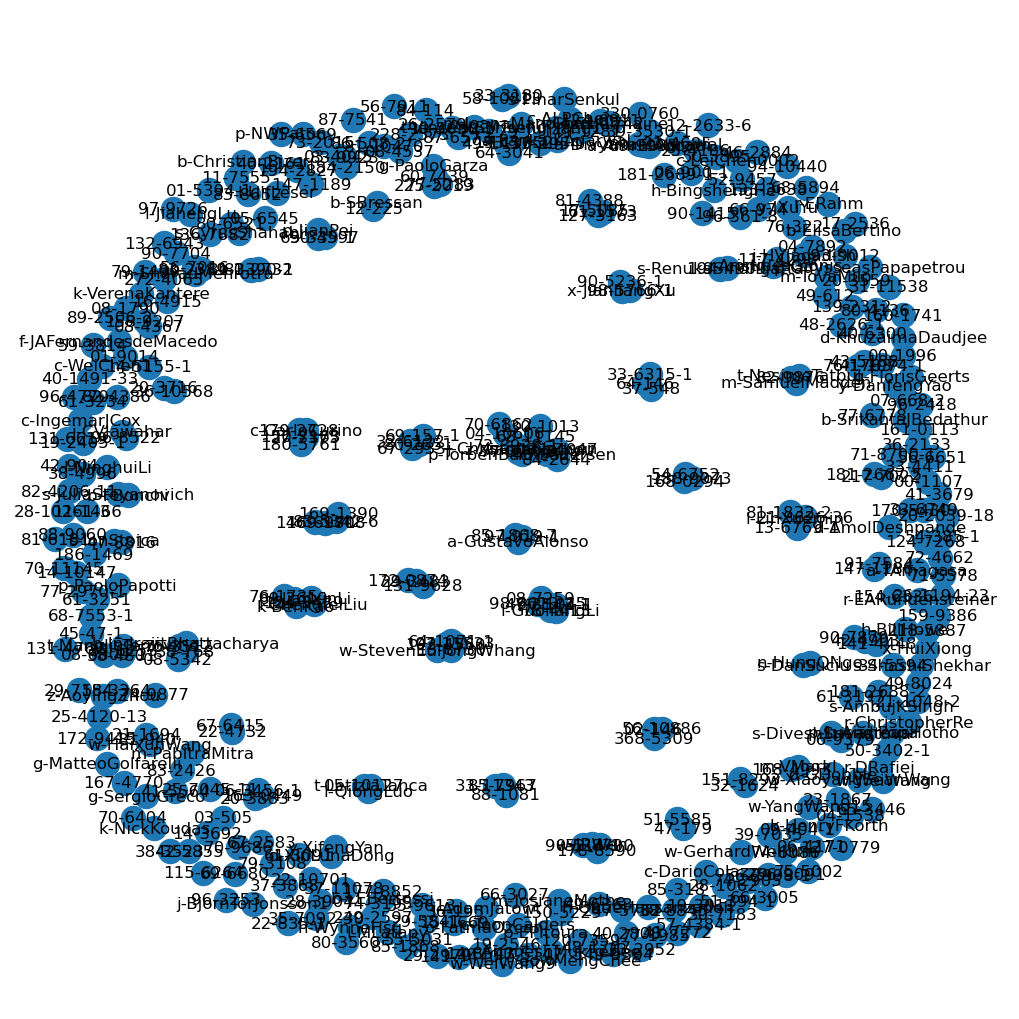

In [17]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True)

In [18]:
# Convert to DataFrame
real_stats_df = pd.DataFrame.from_dict(yearly_stats, orient='index').sort_index()

# Sort years for the animation frames
years = sorted(year_networks.keys())

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 8))

def update(year):
    ax.clear()  # Clear the previous frame
    G = year_networks[year]
    
    # Compute layout for the current year's network
    pos = nx.spring_layout(G, seed=42)  # using a fixed seed for consistency
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue', ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    
    ax.set_title(f'Collaboration Network for Year {year}', fontsize=16)
    ax.axis('off')

# Create the animation; adjust interval (in ms) as needed
ani = FuncAnimation(fig, update, frames=years, interval=1000, repeat=True)

# For Jupyter Notebooks: display the animation as HTML
HTML(ani.to_jshtml())

display result

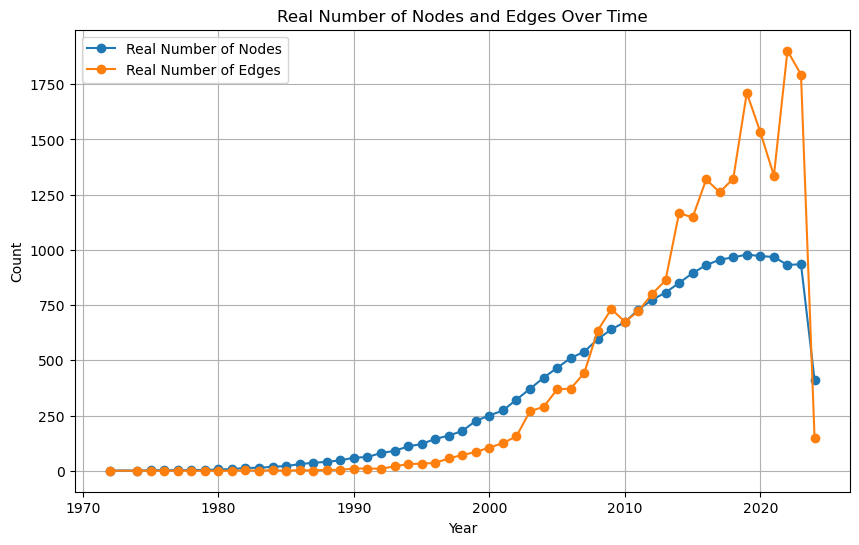

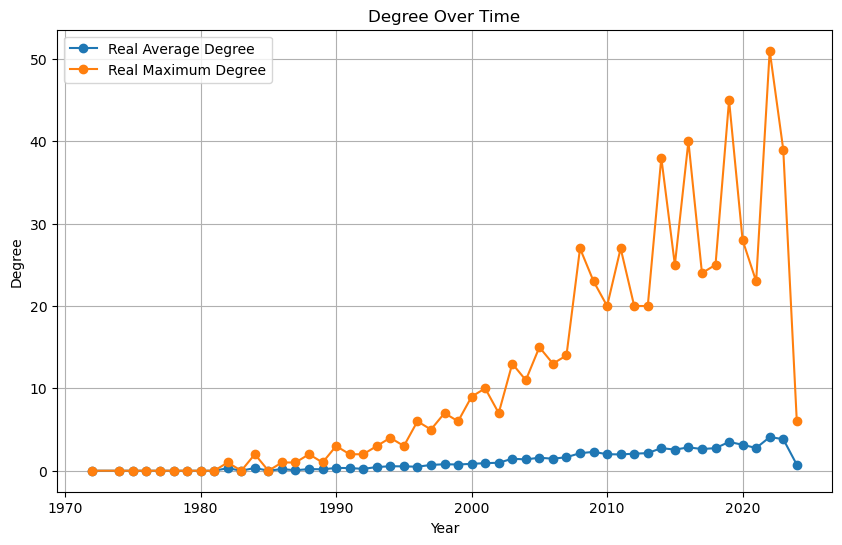

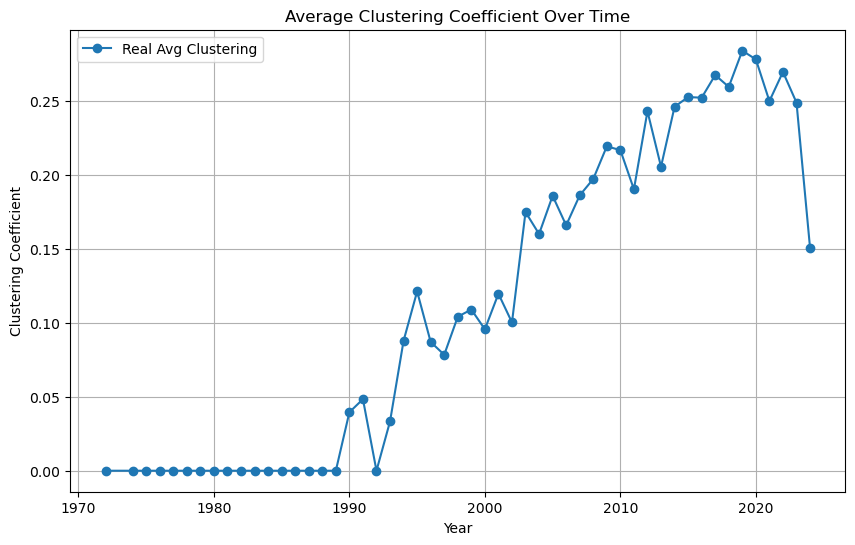

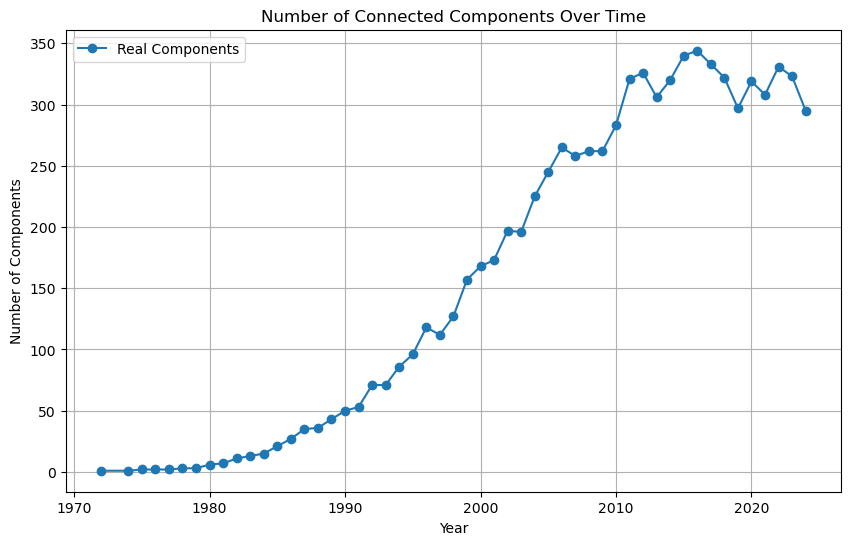

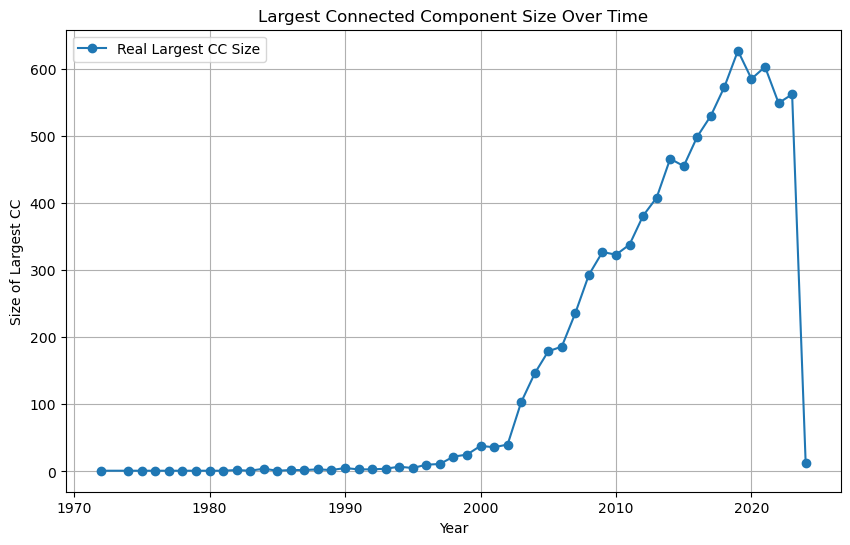

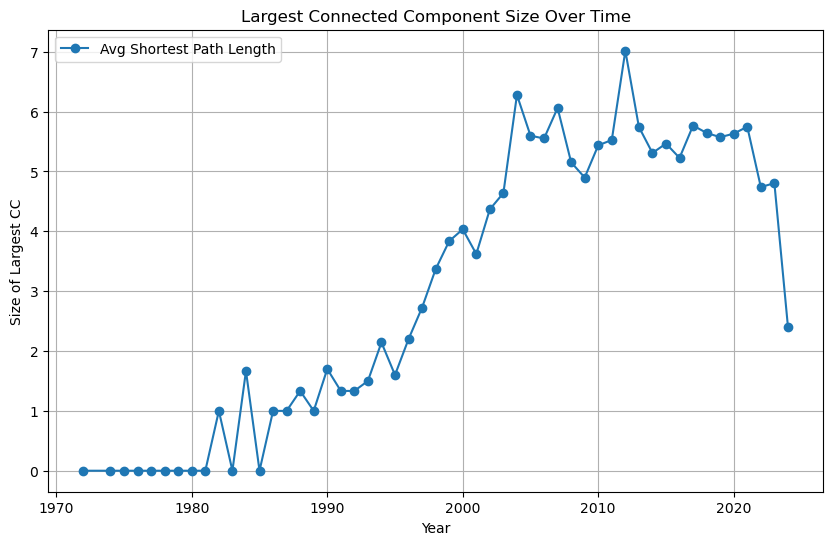

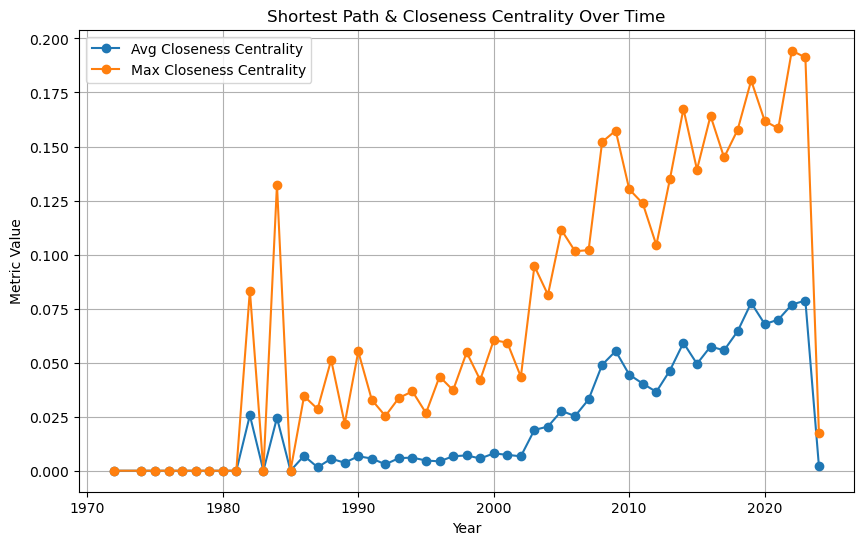

In [20]:
# -------------------------------
# Graph 1: Real Number of Nodes and Real Number of Edges
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_num_nodes'], marker='o', label='Real Number of Nodes')
plt.plot(real_stats_df.index, real_stats_df['real_num_edges'], marker='o', label='Real Number of Edges')
plt.title('Real Number of Nodes and Edges Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 2: Average Degree and Maximum Degree Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_avg_degree'], marker='o', label='Real Average Degree')
plt.plot(real_stats_df.index, real_stats_df['real_max_degree'], marker='o', label='Real Maximum Degree')
plt.title('Degree Over Time')
plt.xlabel('Year')
plt.ylabel('Degree')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 3: Average Clustering Coefficient Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_avg_clustering'], marker='o', label='Real Avg Clustering')
plt.title('Average Clustering Coefficient Over Time')
plt.xlabel('Year')
plt.ylabel('Clustering Coefficient')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 4: Number of Connected Components Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_num_components'], marker='o', label='Real Components')
plt.title('Number of Connected Components Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 5: Largest Connected Component Size Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_largest_cc_size'], marker='o', label='Real Largest CC Size')
plt.title('Largest Connected Component Size Over Time')
plt.xlabel('Year')
plt.ylabel('Size of Largest CC')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 6: Shortest Path Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_avg_shortest_path_length'], marker='o', label='Avg Shortest Path Length')
plt.title('Largest Connected Component Size Over Time')
plt.xlabel('Year')
plt.ylabel('Size of Largest CC')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Graph 7: Shortest Path and Closeness Centrality Metrics Over Time
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(real_stats_df.index, real_stats_df['real_avg_closeness'], marker='o', label='Avg Closeness Centrality')
plt.plot(real_stats_df.index, real_stats_df['real_max_closeness'], marker='o', label='Max Closeness Centrality')
plt.title('Shortest Path & Closeness Centrality Over Time')
plt.xlabel('Year')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

### Question 3

Assume that we create a random network from the set of individuals in the input
file. How does the properties of this network differ from the real collaboration
network in (1)?

In [21]:
random_nodes = scientists_df['pid'].astype(str).unique()
n_random = len(random_nodes)

In [22]:
# For each year, create a random network over all scientists (using pids) 
# with the same number of edges as in the real collaboration network.
for year, stats in yearly_stats.items():
    # Number of edges in the real network for this year
    m_real = stats['real_num_edges']
    
    # Create a random graph with n_random nodes and m_real edges
    G_random = nx.gnm_random_graph(n_random, m_real)
    
    # Relabel the random graph nodes with the actual pids from scientists_clean.csv.
    mapping = {i: random_nodes[i] for i in range(n_random)}
    G_random = nx.relabel_nodes(G_random, mapping)
    
    # Compute random network metrics
    rand_num_nodes = G_random.number_of_nodes()      # should equal n_random
    rand_num_edges = G_random.number_of_edges()        # equals m_real
    rand_avg_degree = sum(dict(G_random.degree()).values()) / rand_num_nodes
    rand_avg_clustering = nx.average_clustering(G_random)
    rand_num_components = nx.number_connected_components(G_random)
    rand_largest_cc_size = len(max(nx.connected_components(G_random), key=len))
    
    rand_max_degree = max(dict(G_random.degree()).values())
    
    # Compute average shortest path length on the largest connected component
    rand_largest_cc = max(nx.connected_components(G), key=len)
    rand_G_lcc = G.subgraph(rand_largest_cc)
    rand_avg_shortest_path_length = nx.average_shortest_path_length(rand_G_lcc)
    
    # Compute closeness centrality for all nodes in G
    rand_closeness = nx.closeness_centrality(G_random)
    rand_avg_closeness = sum(rand_closeness.values()) / len(rand_closeness)
    rand_max_closeness = max(rand_closeness.values())


    # Extend the existing metrics with those from the random network.
    stats.update({
        'rand_total_nodes': rand_num_nodes,
        'rand_num_edges': rand_num_edges,
        'rand_avg_degree': rand_avg_degree,
        'rand_avg_clustering': rand_avg_clustering,
        'rand_num_components': rand_num_components,
        'rand_largest_cc_size': rand_largest_cc_size,
        'rand_avg_shortest_path_length': rand_avg_shortest_path_length,
        'rand_avg_closeness': rand_avg_closeness,
        'rand_max_closeness': rand_max_closeness,
        'rand_max_degree': rand_max_degree
    })

# Convert the extended dictionary to a DataFrame for display and plotting.
random_stats_df = pd.DataFrame.from_dict(yearly_stats, orient='index').sort_index()

plot graph

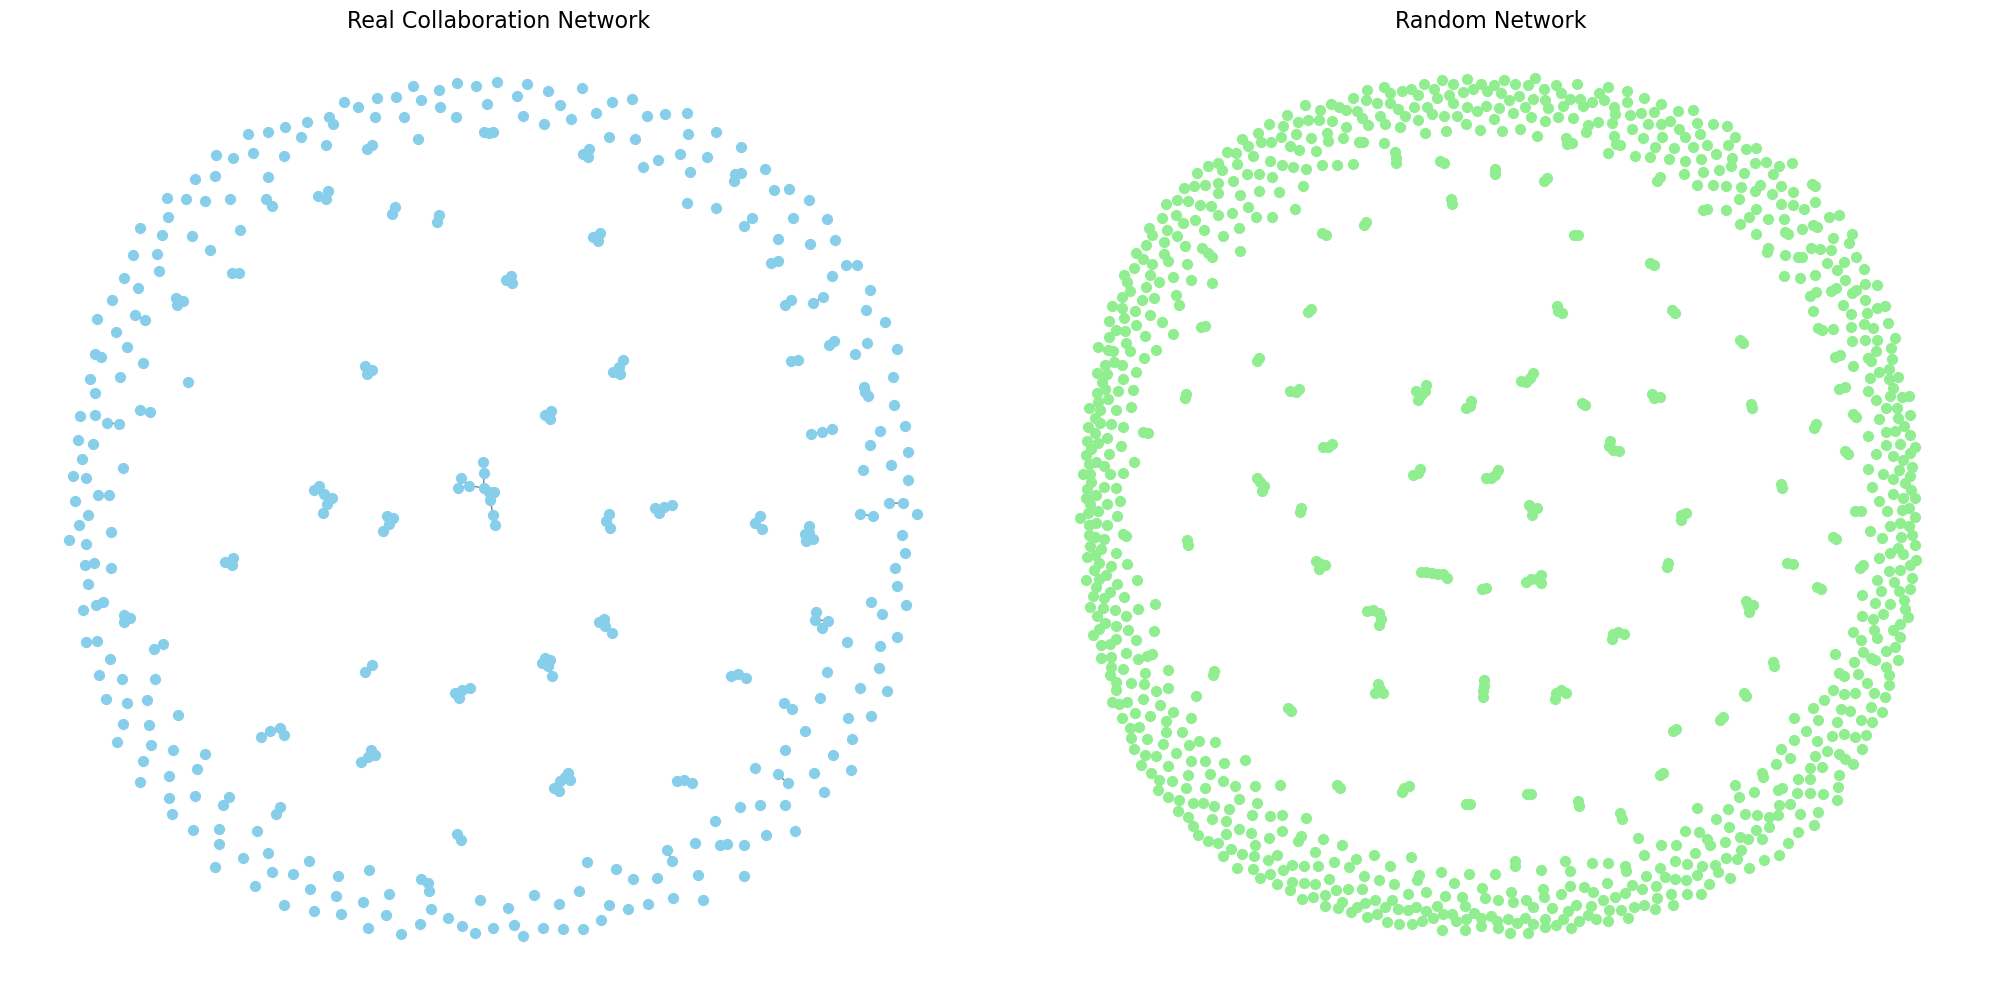

In [23]:

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Compute spring layouts for a good and consistent layout (fixing a seed for reproducibility)
pos_real = nx.spring_layout(G, seed=42)
pos_random = nx.spring_layout(G_random, seed=42)

# Draw the real network on the first subplot
nx.draw_networkx_nodes(G, pos_real, node_size=50, node_color='skyblue', ax=axes[0])
nx.draw_networkx_edges(G, pos_real, alpha=0.5, ax=axes[0])
axes[0].set_title("Real Collaboration Network", fontsize=16)
axes[0].axis('off')

# Draw the random network on the second subplot
nx.draw_networkx_nodes(G_random, pos_random, node_size=50, node_color='lightgreen', ax=axes[1])
nx.draw_networkx_edges(G_random, pos_random, alpha=0.5, ax=axes[1])
axes[1].set_title("Random Network", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

plotting

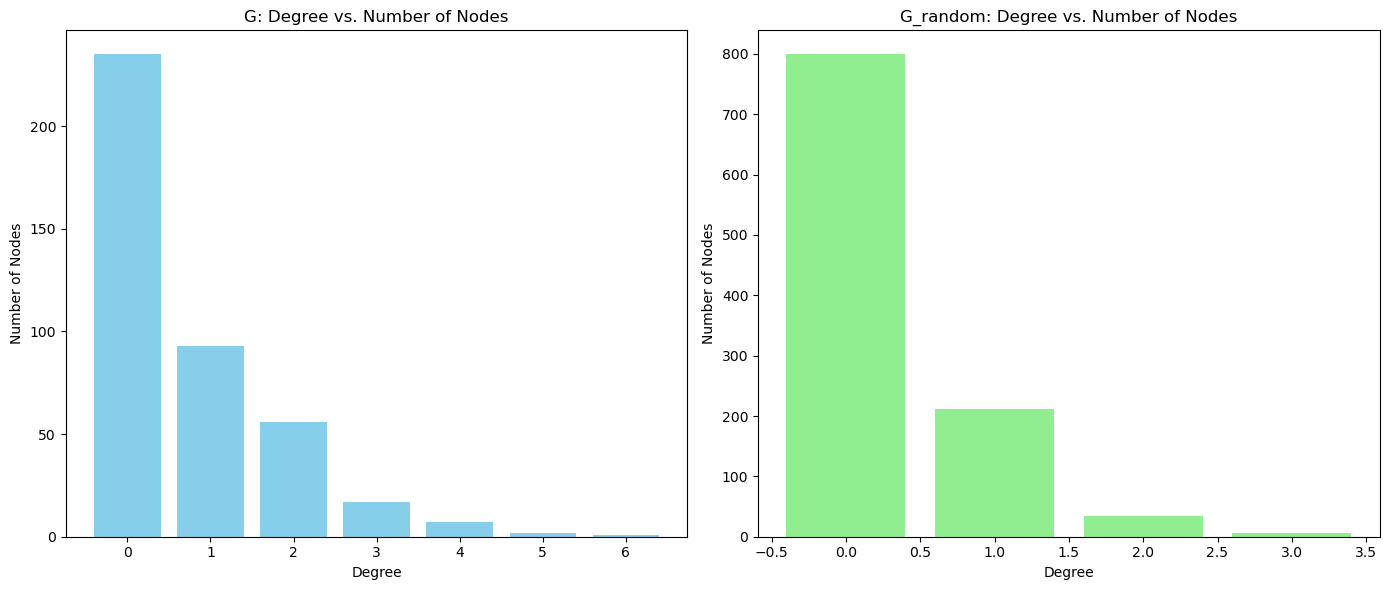

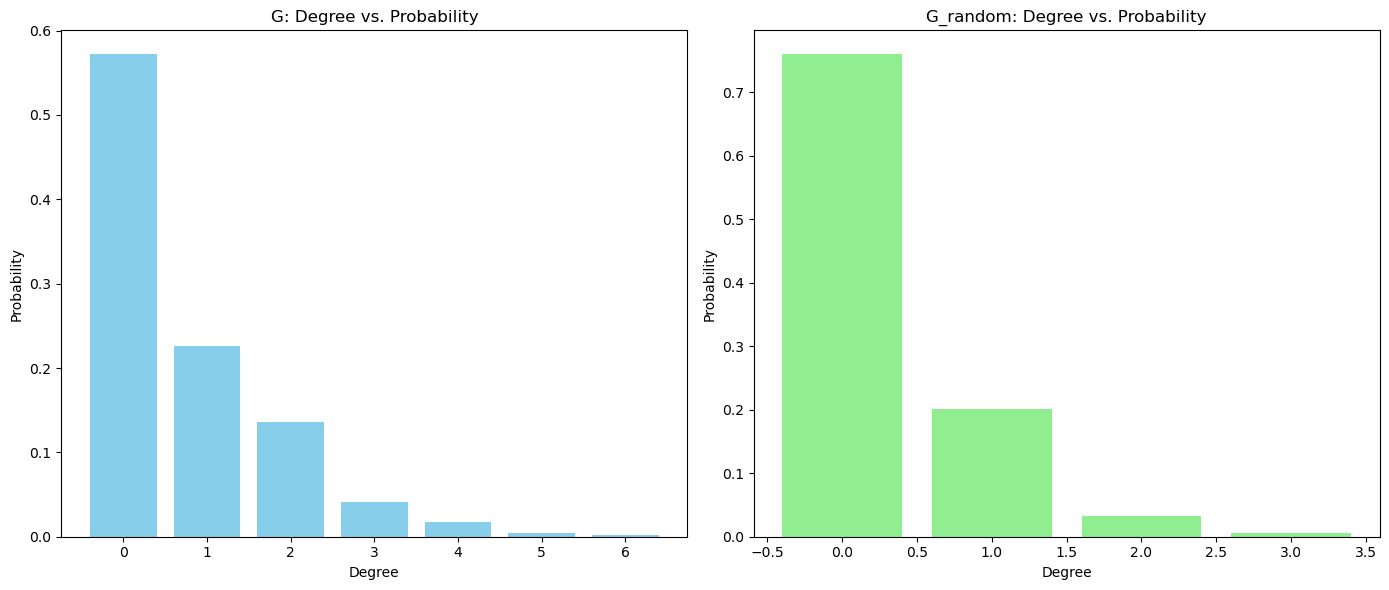

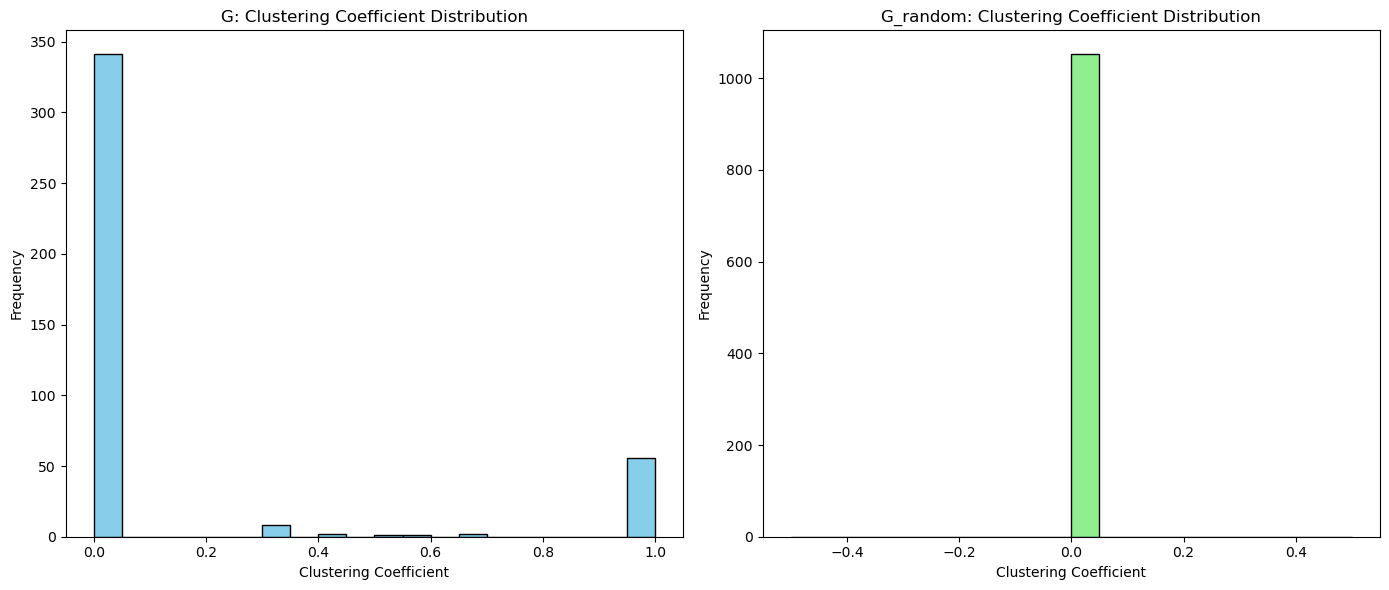

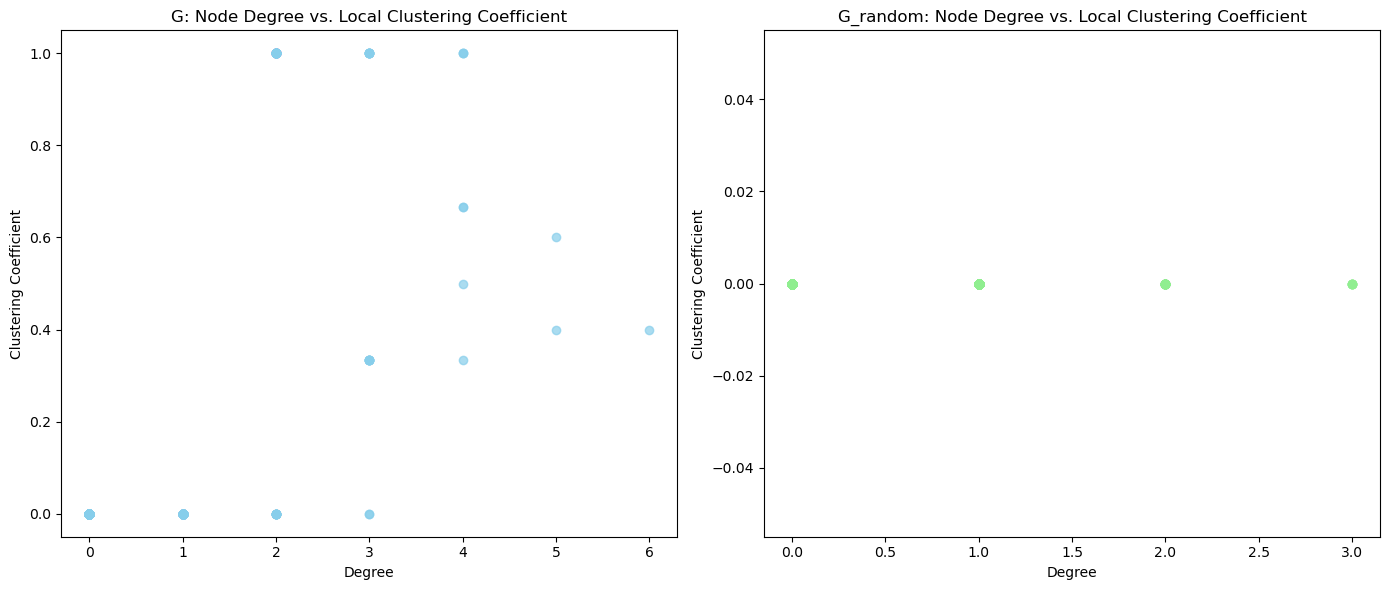

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import collections

# -------------------------------------------
# 1. Plot Degree vs. Number of Nodes
# -------------------------------------------

# Compute the degree distribution for G (real network)
degree_sequence_G = [d for n, d in G.degree()]
degree_count_G = collections.Counter(degree_sequence_G)
deg_G, count_G = zip(*sorted(degree_count_G.items()))

# Compute the degree distribution for G_random (random network)
degree_sequence_R = [d for n, d in G_random.degree()]
degree_count_R = collections.Counter(degree_sequence_R)
deg_R, count_R = zip(*sorted(degree_count_R.items()))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(deg_G, count_G, color='skyblue')
axes[0].set_title("G: Degree vs. Number of Nodes")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Number of Nodes")

axes[1].bar(deg_R, count_R, color='lightgreen')
axes[1].set_title("G_random: Degree vs. Number of Nodes")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Number of Nodes")

plt.tight_layout()
plt.show()


# -------------------------------------------
# 2. Plot Degree vs. Probability
# -------------------------------------------

# For G (real network): Normalize counts to get probability distribution
total_nodes_G = G.number_of_nodes()
prob_G = [cnt / total_nodes_G for cnt in count_G]

# For G_random (random network): Normalize counts to get probability distribution
total_nodes_R = G_random.number_of_nodes()
prob_R = [cnt / total_nodes_R for cnt in count_R]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(deg_G, prob_G, color='skyblue')
axes[0].set_title("G: Degree vs. Probability")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Probability")

axes[1].bar(deg_R, prob_R, color='lightgreen')
axes[1].set_title("G_random: Degree vs. Probability")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Probability")

plt.tight_layout()
plt.show()


# -------------------------------------------
# 3. Plot Histogram of Clustering Coefficient Distribution
# -------------------------------------------

# Compute the local clustering coefficients
clust_G = list(nx.clustering(G).values())
clust_R = list(nx.clustering(G_random).values())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].hist(clust_G, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("G: Clustering Coefficient Distribution")
axes[0].set_xlabel("Clustering Coefficient")
axes[0].set_ylabel("Frequency")

axes[1].hist(clust_R, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title("G_random: Clustering Coefficient Distribution")
axes[1].set_xlabel("Clustering Coefficient")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# -------------------------------------------
# 4. Plot Node Degree vs. Local Clustering Coefficient
# -------------------------------------------

# For G: Create lists of degree and clustering coefficient values
deg_dict_G = dict(G.degree())
clust_dict_G = nx.clustering(G)
x_G = list(deg_dict_G.values())
y_G = [clust_dict_G[node] for node in G.nodes()]

# For G_random: Create lists of degree and clustering coefficient values
deg_dict_R = dict(G_random.degree())
clust_dict_R = nx.clustering(G_random)
x_R = list(deg_dict_R.values())
y_R = [clust_dict_R[node] for node in G_random.nodes()]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(x_G, y_G, color='skyblue', alpha=0.7)
axes[0].set_title("G: Node Degree vs. Local Clustering Coefficient")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Clustering Coefficient")

axes[1].scatter(x_R, y_R, color='lightgreen', alpha=0.7)
axes[1].set_title("G_random: Node Degree vs. Local Clustering Coefficient")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Clustering Coefficient")

plt.tight_layout()
plt.show()

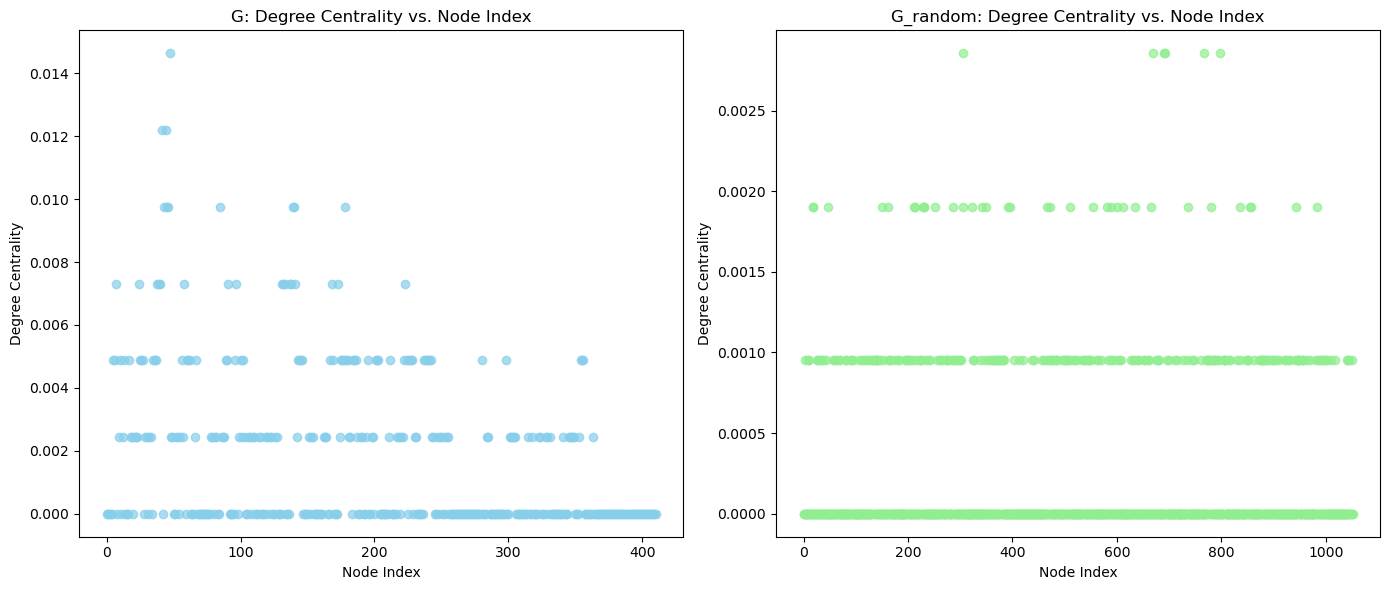

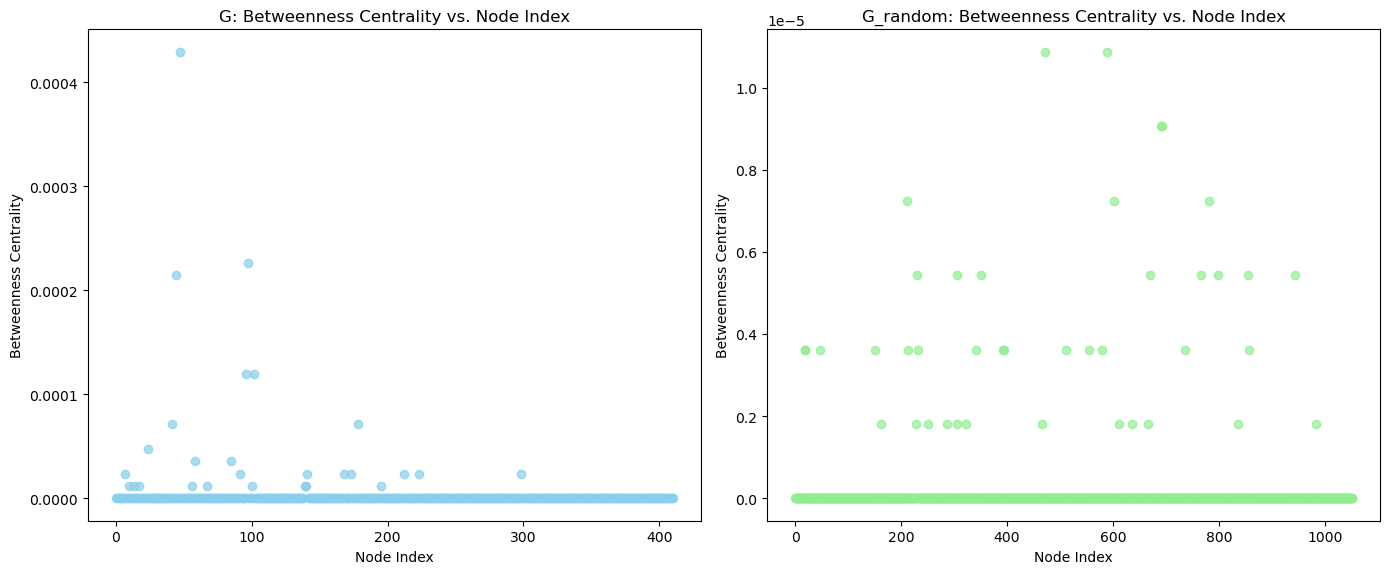

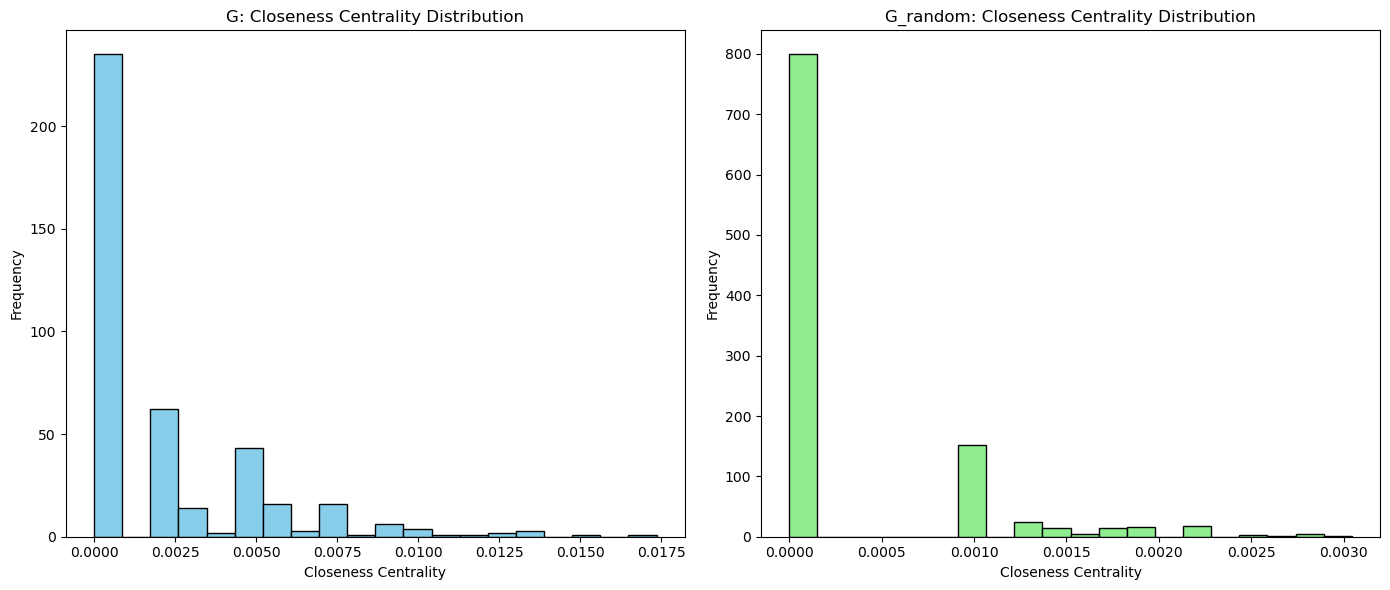

In [25]:
# ------------------------------
# Compute centralities for real network G
# ------------------------------
deg_centr_G = nx.degree_centrality(G)         # returns a dict {node: centrality, ...}
betw_centr_G = nx.betweenness_centrality(G)     # likewise, for betweenness
clos_centr_G = nx.closeness_centrality(G)        # closeness centrality

# Get lists of nodes and corresponding values for G
nodes_G = list(deg_centr_G.keys())
deg_values_G = [deg_centr_G[node] for node in nodes_G]
betw_values_G = [betw_centr_G[node] for node in nodes_G]
clos_values_G = list(clos_centr_G.values())

# ------------------------------
# Compute centralities for random network G_random
# ------------------------------
deg_centr_R = nx.degree_centrality(G_random)
betw_centr_R = nx.betweenness_centrality(G_random)
clos_centr_R = nx.closeness_centrality(G_random)

# Get lists of nodes and corresponding values for G_random
nodes_R = list(deg_centr_R.keys())
deg_values_R = [deg_centr_R[node] for node in nodes_R]
betw_values_R = [betw_centr_R[node] for node in nodes_R]
clos_values_R = list(clos_centr_R.values())

# ------------------------------
# Plot 1: Degree Centrality vs. Node Index
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# For real network G
axes[0].scatter(range(len(nodes_G)), deg_values_G, color='skyblue', alpha=0.7)
axes[0].set_title("G: Degree Centrality vs. Node Index")
axes[0].set_xlabel("Node Index")
axes[0].set_ylabel("Degree Centrality")

# For random network G_random
axes[1].scatter(range(len(nodes_R)), deg_values_R, color='lightgreen', alpha=0.7)
axes[1].set_title("G_random: Degree Centrality vs. Node Index")
axes[1].set_xlabel("Node Index")
axes[1].set_ylabel("Degree Centrality")

plt.tight_layout()
plt.show()

# ------------------------------
# Plot 2: Betweenness Centrality vs. Node Index
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# For real network G
axes[0].scatter(range(len(nodes_G)), betw_values_G, color='skyblue', alpha=0.7)
axes[0].set_title("G: Betweenness Centrality vs. Node Index")
axes[0].set_xlabel("Node Index")
axes[0].set_ylabel("Betweenness Centrality")

# For random network G_random
axes[1].scatter(range(len(nodes_R)), betw_values_R, color='lightgreen', alpha=0.7)
axes[1].set_title("G_random: Betweenness Centrality vs. Node Index")
axes[1].set_xlabel("Node Index")
axes[1].set_ylabel("Betweenness Centrality")

plt.tight_layout()
plt.show()

# ------------------------------
# Plot 3: Histogram of Closeness Centrality
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for real network G
axes[0].hist(clos_values_G, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("G: Closeness Centrality Distribution")
axes[0].set_xlabel("Closeness Centrality")
axes[0].set_ylabel("Frequency")

# Histogram for random network G_random
axes[1].hist(clos_values_R, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title("G_random: Closeness Centrality Distribution")
axes[1].set_xlabel("Closeness Centrality")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

does 1 individual becoming a hub leads to a large giant conponent size? 

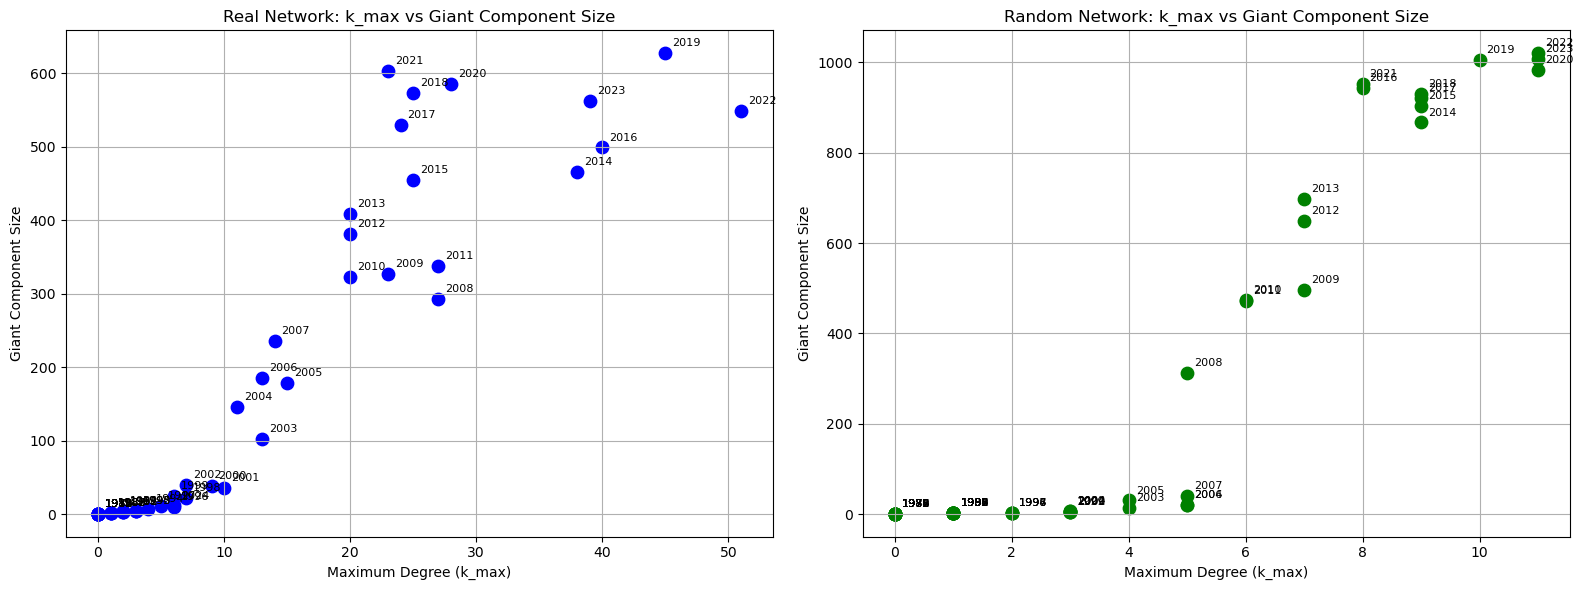

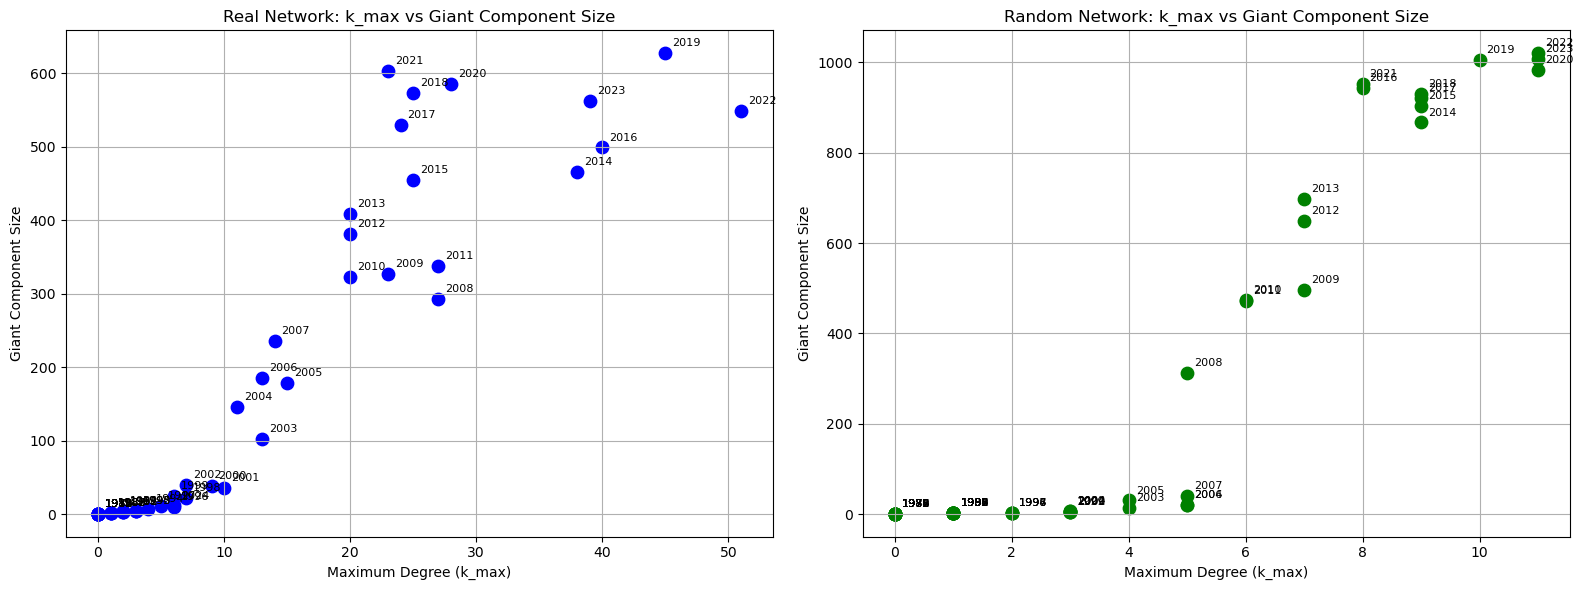

In [30]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (one for the real network and one for the random network)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Real network scatter plot
axes[0].scatter(real_stats_df['real_max_degree'], real_stats_df['real_largest_cc_size'], 
                color='blue', marker='o', s=80, label='Real')
axes[0].set_title('Real Network: k_max vs Giant Component Size')
axes[0].set_xlabel('Maximum Degree (k_max)')
axes[0].set_ylabel('Giant Component Size')
axes[0].grid(True)

# Optionally, annotate each point with its year
for i, year in enumerate(real_stats_df.index):
    axes[0].annotate(str(year),
                     (real_stats_df['real_max_degree'].iloc[i], real_stats_df['real_largest_cc_size'].iloc[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=8)

# Right subplot: Random network scatter plot
axes[1].scatter(random_stats_df['rand_max_degree'], random_stats_df['rand_largest_cc_size'], 
                color='green', marker='o', s=80, label='Random')
axes[1].set_title('Random Network: k_max vs Giant Component Size')
axes[1].set_xlabel('Maximum Degree (k_max)')
axes[1].set_ylabel('Giant Component Size')
axes[1].grid(True)

# Optionally, annotate each point with its year
for i, year in enumerate(real_stats_df.index):
    axes[1].annotate(str(year),
                     (random_stats_df['rand_max_degree'].iloc[i], random_stats_df['rand_largest_cc_size'].iloc[i]),
                     textcoords="offset points", xytext=(5,5), fontsize=8)

plt.tight_layout()
plt.show()